# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import torch
import numpy as np
import pandas as pd
import arff
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import seaborn as sns
import skunk
from matplotlib import colormaps, patches
from sklearn.metrics import roc_auc_score, roc_curve
from typing import Sequence, ValuesView
from string import ascii_letters
from timeit import timeit, repeat
from datetime import datetime
from itertools import combinations, combinations_with_replacement
from IPython.display import display, SVG
import graphviz

from ttn_torch import TIndex, TTNIndex, TTN, TTNModel, check_correct_init
from algebra import contract_up, sep_partial_dm_torch
from utils import *
import sys
sys.path.insert(0, '../')

from images.plot_utils import *
from torchinfo import summary

from tqdm.notebook import tqdm, trange
FONTSIZE = 14

/home/alberto/.pyenv/versions/ttn4hep/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/alberto/.pyenv/versions/ttn4hep/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## TTN with automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

In [4]:
DEVICE = 'cuda'
DTYPE = torch.double
N_FEAT = 8
ttn = TTN(N_FEAT, bond_dim=8, n_labels=2, device=DEVICE, dtype=DTYPE)
ttn.draw()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Basic operations
General purpose contraction, not optimized

In [4]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [6]:
def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,bj,ijk->bk', data_tensors[0], data_tensors[1], tensor)

### Tests

In [10]:
data = torch.rand(N_FEAT, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(N_FEAT)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

(0.5977598046883941, 5.053641706239432, 3.2214218070730567)

In [106]:
map_dim = [2, 4, 8, 16, 32]
batch_dims = [10, 100, 1000, 10000]

df_cpu = pd.DataFrame(columns=['contract_up', 'contract_up_einsum'], index=pd.MultiIndex.from_product([batch_dims, map_dim], names=['batch_dim', 'map_dim']))
df_gpu = pd.DataFrame(columns=['contract_up', 'contract_up_einsum'], index=pd.MultiIndex.from_product([batch_dims, map_dim], names=['batch_dim', 'map_dim']))

DTYPE = torch.double
DEVICE = 'cpu'
pbar = tqdm(total=len(batch_dims)*len(map_dim), desc='CPU')
for bd in batch_dims:
    for md in map_dim:
        pbar.set_postfix({'batch_dim': bd, 'map_dim': md})
        data = torch.rand(2, bd, md, dtype=DTYPE, device=DEVICE).unbind(0)
        tensor = torch.rand(md, md, 16, dtype=DTYPE, device=DEVICE)

        time1 = min(repeat(lambda: contract_up(tensor, data), number=100, repeat=10))
        time2 = min(repeat(lambda: contract_up_einsum(tensor, data), number=100, repeat=10))
        df_cpu.loc[(bd, md), 'contract_up'] = time1
        df_cpu.loc[(bd, md), 'contract_up_einsum'] = time2
        pbar.update(1)
pbar.close()

DEVICE = 'cuda'
pbar = tqdm(total=len(batch_dims)*len(map_dim), desc='GPU')
for bd in batch_dims:
    for md in map_dim:
        pbar.set_postfix({'batch_dim': bd, 'map_dim': md})
        data = torch.rand(2, bd, md, dtype=DTYPE, device=DEVICE).unbind(0)
        tensor = torch.rand(md, md, 16, dtype=DTYPE, device=DEVICE)

        time1 = min(repeat(lambda: contract_up(tensor, data), number=1000, repeat=10))
        time2 = min(repeat(lambda: contract_up_einsum(tensor, data), number=1000, repeat=10))
        df_gpu.loc[(bd, md), 'contract_up'] = time1
        df_gpu.loc[(bd, md), 'contract_up_einsum'] = time2
        pbar.update(1)
pbar.close()
        


CPU:   0%|          | 0/20 [00:00<?, ?it/s]

GPU:   0%|          | 0/20 [00:00<?, ?it/s]

In [107]:
df_cpu['ratio'] = df_cpu['contract_up_einsum'] / df_cpu['contract_up']
df_gpu['ratio'] = df_gpu['contract_up_einsum'] / df_gpu['contract_up']
df_gpu['contract_up'] = df_gpu['contract_up'] / 10
df_gpu['contract_up_einsum'] = df_gpu['contract_up_einsum'] / 10

In [97]:
df_cpu.pivot_table(index='map_dim', columns='batch_dim', values='ratio')

batch_dim,10,100,1000
map_dim,,,
2,12.169727,9.38122,3.201761
4,12.131401,8.598793,2.664678
8,11.573363,6.584108,0.379514
16,10.240231,1.002986,4.509165
32,19.607654,0.129305,33.336255


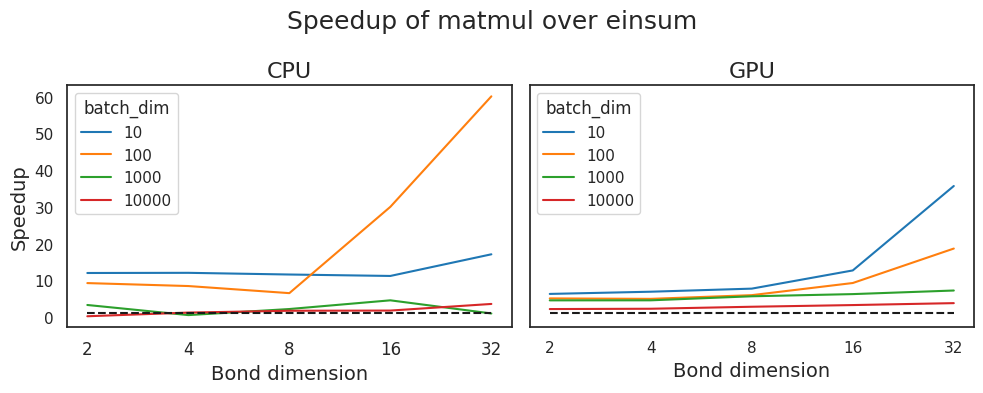

In [110]:
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

sns.lineplot(data=df_cpu, x='map_dim', y='ratio', ax=axes[0], hue='batch_dim', palette='tab10')
sns.lineplot(data=df_gpu, x='map_dim', y='ratio', ax=axes[1], hue='batch_dim', palette='tab10')
axes[0].hlines(1, 2, 32, colors='k', linestyles='dashed', label='1')
axes[1].hlines(1, 2, 32, colors='k', linestyles='dashed', label='1')

axes[0].set_xscale('log')
axes[0].set_xticks(map_dim, map_dim, fontsize=FONTSIZE-2)
axes[0].set_title('CPU', fontsize=FONTSIZE+2)
axes[1].set_title('GPU', fontsize=FONTSIZE+2)
axes[0].set_ylabel('Speedup', fontsize=FONTSIZE)
axes[0].set_xlabel('Bond dimension', fontsize=FONTSIZE)
axes[1].set_xlabel('Bond dimension', fontsize=FONTSIZE)
fig.suptitle('Speedup of matmul over einsum', fontsize=FONTSIZE+4)
fig.tight_layout()
fig.show()
fig.savefig('../images/speedup_matmul_einsum2.pdf')

In [12]:
data = torch.rand(N_FEAT, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(N_FEAT)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

0.044563944917172194 0.037131879944354296 0.10482608387246728


TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [13]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['i'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

ttn test: 100%|██████████| 3/3 [00:00<00:00, 29.90it/s, contracted 0.0] 


tensor([1., 0.], dtype=torch.float64)

In [12]:
imsize = '16x16'

train = np.load('../data/stripeimages/' + imsize + 'train.npy')
test = np.load('../data/stripeimages/' + imsize + 'test.npy')

train_linear = linearize(torch.tensor(train)).to(dtype=torch.float32)
test_linear = linearize(torch.tensor(test)).to(dtype=torch.float32)

np.save('../data/stripeimages/' + imsize + 'train_linear.npy', train_linear)
np.save('../data/stripeimages/' + imsize + 'test_linear.npy', test_linear)

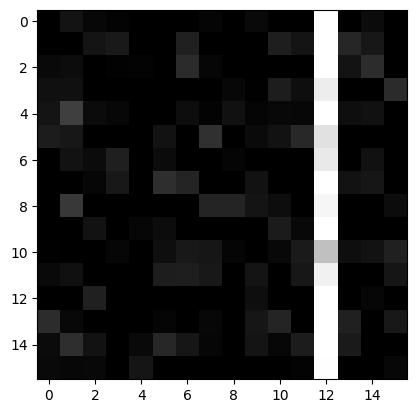

In [15]:
plt.imshow(train[0], cmap='gray')

## Torch Model

### Test the model

In [ ]:
h = 8
features = h**2
BATCH_SIZE = 5000
DATASET = 'hls'
MAPPING = 'spin'
MAP_DIM = 2

iris_features = ['SL', 'SW', 'PL', 'PW']

if DATASET == 'mnist':
    train_dl, test_dl, train_visual, features = get_mnist_data_loaders(h, batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM, labels=[0, 1])
elif DATASET == 'stripe':
    train_dl, test_dl, features = get_stripeimage_data_loaders(4, h, batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'iris':
    # worst performance with iris-versicolor and iris-virginica
    train_dl, test_dl, features = get_iris_data_loaders(batch_size=BATCH_SIZE, sel_labels=['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'higgs':
    train_dl, test_dl, features = get_higgs_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
elif DATASET == 'titanic':
    train_dl, test_dl, features = get_titanic_data_loaders(batch_size=BATCH_SIZE, scale=(0, 1), mapping=MAPPING, dim=MAP_DIM)   # scales different from (0, 1) are reasonable only in the poly mapping
elif DATASET == 'bbdata':
    train_dl, test_dl, features = get_bb_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM, permutation=[0,1,5,7,10,12,13,15])#permutation=[0,1,5,7,10,12,14,15]
elif DATASET == 'hls':
    train_dl, test_dl, features = get_hls_data_loaders(batch_size=BATCH_SIZE, mapping=MAPPING, dim=MAP_DIM)
else:
    raise ValueError(f"Unknown dataset: {DATASET}")



In [5]:
len(train_dl.dataset), len(test_dl.dataset), features

(644264, 161066, 16)

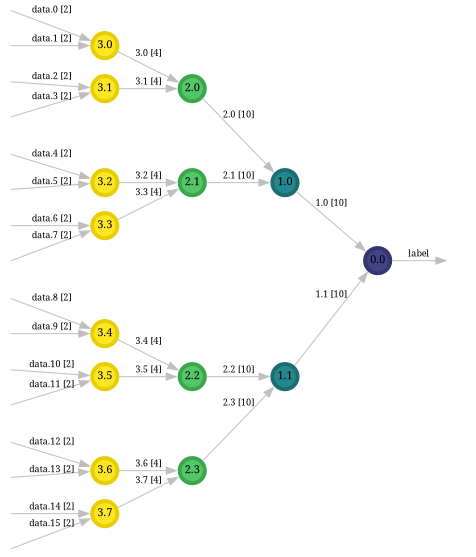

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BOND_DIM = 10
DTYPE = torch.double
N_LABELS = 5
MODEL_DIR = f'{DATASET}_models'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model = TTNModel(features, n_phys=MAP_DIM, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
model.draw()

In [7]:
next(iter(train_dl))[1][:10]

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]], dtype=torch.float64)

In [8]:
INIT_EPOCHS = 2
loss = lambda *x: class_loss_fn(*x, l=0.01)
#loss = ClassLoss(0.1, transform=torch.tanh)

model.initialize(True, train_dl, loss, INIT_EPOCHS)

ttn supervised init:   0%|          | 0/129 [00:00<?, ?it/s]/home/alberto/.pyenv/versions/ttn4hep/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
ttn supervised init:   0%|          | 0/129 [00:32<?, ?it/s, doing epoch 2/2]


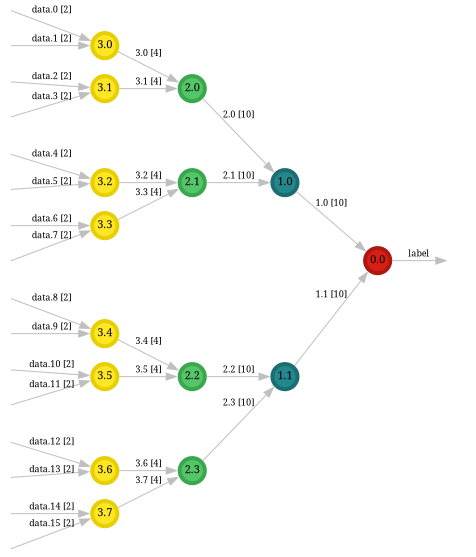

In [9]:
model.draw()

In [10]:
print(check_correct_init(model))
summary(model, input_size=(BATCH_SIZE, features, MAP_DIM), dtypes=[DTYPE], device=DEVICE)

(True, 0)


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [5000, 5]                 3,268
Total params: 3,268
Trainable params: 3,268
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.28
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.28

### Train with global SGD

In [8]:
LR = .2
EPOCHS = 50
gauging = False
LAMBDA = 10
SCHEDULER_STEPS = 5
#LOSS = lambda *x: class_loss_fn(*x, l=LAMBDA) 
#LOSS = ClassLoss(LAMBDA)
LOSS = loss

model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [9]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, LOSS, optimizer, gauging = gauging)
    tot_loss_history += loss_history

    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()
        #pass
   
loss_history = np.array(tot_loss_history)

epochs:   0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.39it/s, current loss=0.0489, batches -10-0 loss=0, epoch mean loss=0.0547]


### Train with sweeping

In [12]:
EPOCHS = 2
SWEEPS = 20
loss = lambda*x: class_loss_fn(*x, l=0.)
optimizer = torch.optim.Adam(model.parameters(), 2**(model.n_layers-6)) #2**(model.n_layers-6)

In [13]:
loss_history = []
grads_magnitude = []
now = datetime.now()
for s in trange(SWEEPS, desc='sweeps', position=0):
    losses, _ = model.sweep(train_dl, dclass_loss_fn, optimizer, epochs=EPOCHS, path_type='layer+0', manual=True, loss=loss, verbose=2, save_grads=False)
    loss_history.extend(losses)
    #grads_magnitude.extend(grads)

loss_history = np.array(loss_history)

sweeps:   0%|          | 0/20 [00:00<?, ?it/s]

ttn swwep, tensor 2.1:  28%|██▊       | 5/18 [04:06<10:40, 49.23s/it, loss: 0.22263408487207093]


KeyboardInterrupt: 

### Get performances

### Load model

In [22]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 16
fl = 10

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="nearest")

DEVICE= 'cuda'
DTYPE = torch.float32
model = TTNModel.from_npz('trenti_models/train_lhcb_bd8/weights.npz', device=DEVICE, dtype=DTYPE, quantizer=None)
model.center='0.0'
model.initialize(False)

In [5]:

model_name = f'{DATASET}_models/model_{DATASET}_bd10_spin_20241001-195044'

MODEL_DIR = model_name.split('/')[0]+'/'
timestamp = model_name.split('_')[-1]
model = TTNModel.from_npz(model_name+'.npz', device='cuda' if torch.cuda.is_available() else 'cpu')
model.initialize(False)
BOND_DIM = model.bond_dim
N_LABELS = model.n_labels
DTYPE= model.dtype
loss_history = np.load(model_name.split('/')[0] + '/loss_history_' + model_name.split('_')[-1] + '.npy')
now = datetime(int(timestamp[:4]), int(timestamp[4:6]), int(timestamp[6:8]), int(timestamp[9:11]), int(timestamp[11:13]), int(timestamp[13:15]))

In [21]:
MODEL_DIR = 'data/search_entropy/'
id = 20
model_name = F'{MODEL_DIR}model_id{id}'
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
model = TTNModel.from_npz(model_name+'.npz', device=DEVICE)
model.initialize(False)
BOND_DIM = model.bond_dim
N_LABELS = model.n_labels
DTYPE= model.dtype
loss_history = np.load('/'.join(model_name.split('/')[:-1]) + '/loss_history_' + model_name.split('_')[-1] + '.npy')

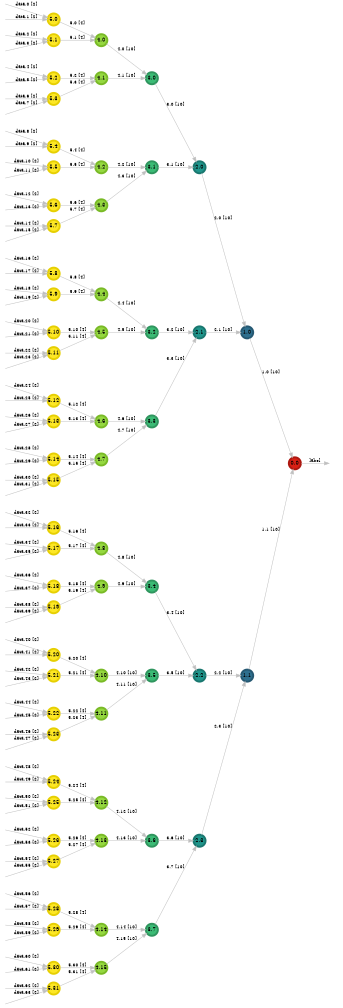

In [6]:
model.draw()

### or not

In [16]:
accuracy(model, DEVICE, train_dl, test_dl, model.dtype)

train: 100%|██████████| 129/129 [00:05<00:00, 23.48it/s]


(0.7293500800913911, 0.7291979685346379)

In [12]:
model.normalize()
model.norm

tensor([2.3006, 3.1860, 1.8281], device='cuda:0', dtype=torch.float64)

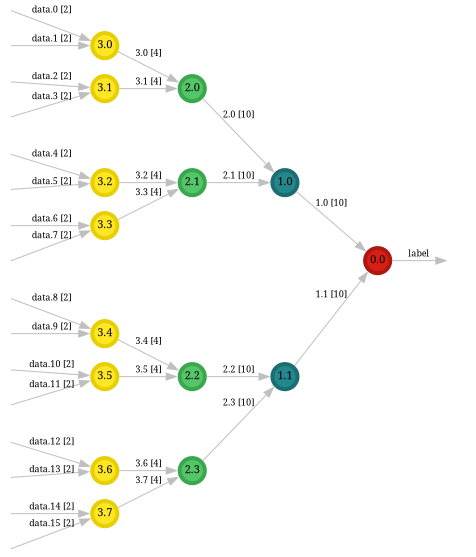

In [15]:
model.canonicalize('0.0')
model.draw()

In [14]:
#torch.save(model.state_dict, MODEL_DIR + f'/trainedmodel_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(MODEL_DIR + f'/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

### Plots

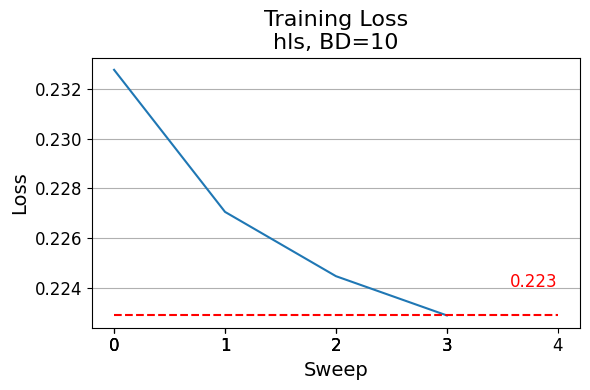

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = plot_loss(loss_history, ax, SWEEPS, FS=FONTSIZE, sweep=True)
ax.set_title(F'Training Loss\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
#ax.set_ylim(1150, 1240)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/loss_history_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

epochs:  50%|█████     | 1/2 [03:05<03:05, 185.74s/it, loss: 0.2212157119044384]


AttributeError: 'numpy.ndarray' object has no attribute 'legend'

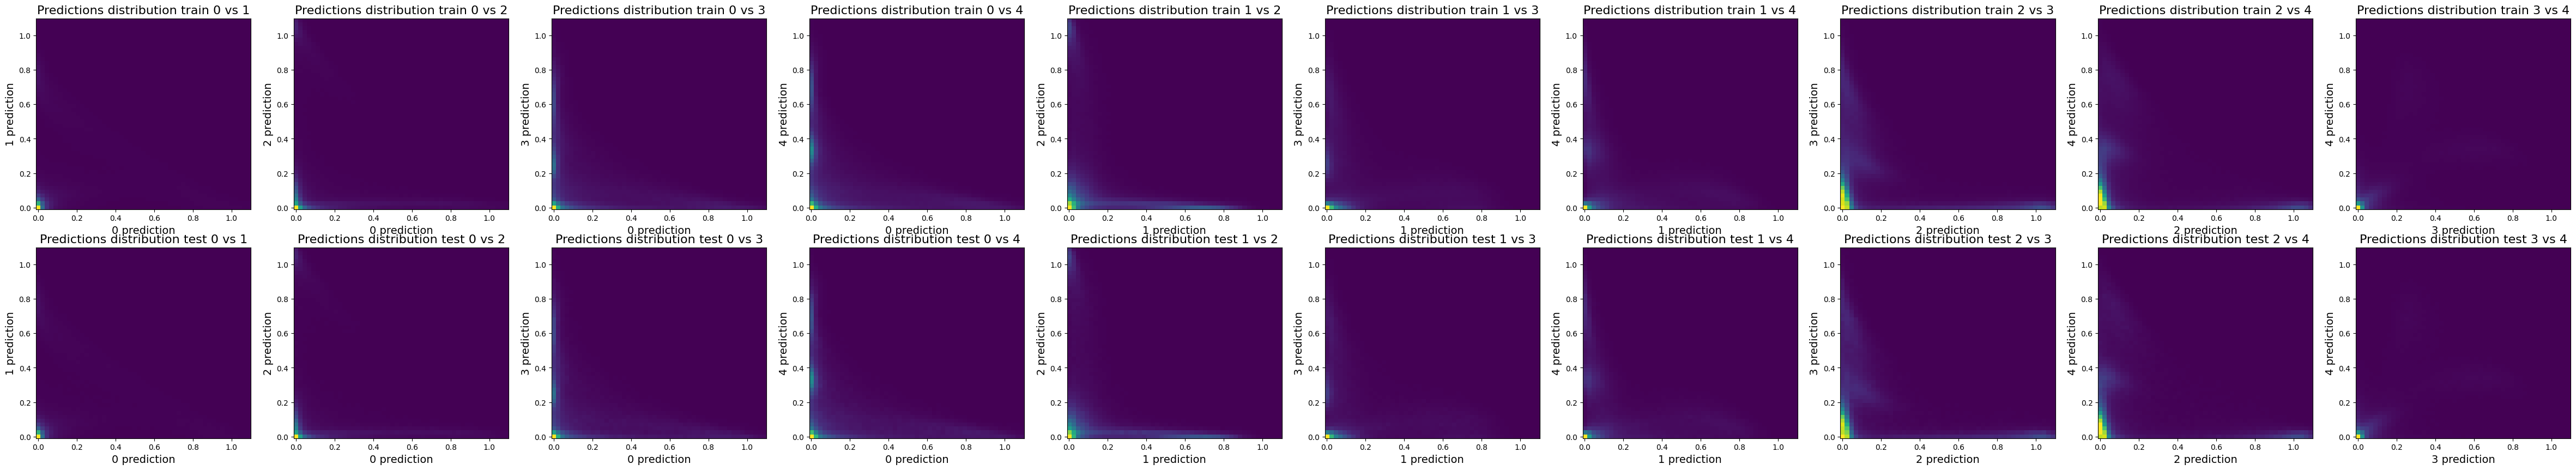

In [20]:
y_train_true = torch.cat([y for _, y in train_dl], dim=0).to(dtype=torch.int).numpy()
y_test_true = torch.cat([y for _, y in test_dl], dim=0).numpy()

train_pred = get_predictions(model, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(model, DEVICE, test_dl, DTYPE)
bins = np.linspace(-0.01, 1.1, 50)
fig, ax = plot_predictions(train_pred, test_pred, N_LABELS, nbins=bins, train_true=y_train_true, test_true=y_test_true, FS=FONTSIZE)

train_acc, test_acc = accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)
legend_patches = []
legend_patches.append(patches.Rectangle([0,0], 0,0, facecolor='white', edgecolor='black', label=f'Train\nacc: {train_acc:.1%}'))
legend_patches.append(patches.Rectangle([0,0], 0,0, facecolor='white', edgecolor='black', hatch='//', label=f'Test\nacc: {test_acc:.1%}'))
legend_patches.append(patches.Rectangle([0,0], 0,0, color='tab:blue', alpha=0.6, label=r'$\bar S$'))
legend_patches.append(patches.Rectangle([0,0], 0,0, color='tab:orange', alpha=0.6, label=r'$S$'))



ax.legend(legend_patches, [patch.get_label() for patch in legend_patches])

ax.set_title(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png', dpi=600) #_{now.strftime("%Y%m%d-%H%M%S")}

In [25]:
fig.suptitle(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [26]:
# save model output
train_out = get_output(model, DEVICE, train_dl, DTYPE)
test_out = get_output(model, DEVICE, test_dl, DTYPE)
np.save(MODEL_DIR + f'/train_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(MODEL_DIR + f'/test_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

### ROC

ROC AUC Score: 0.9


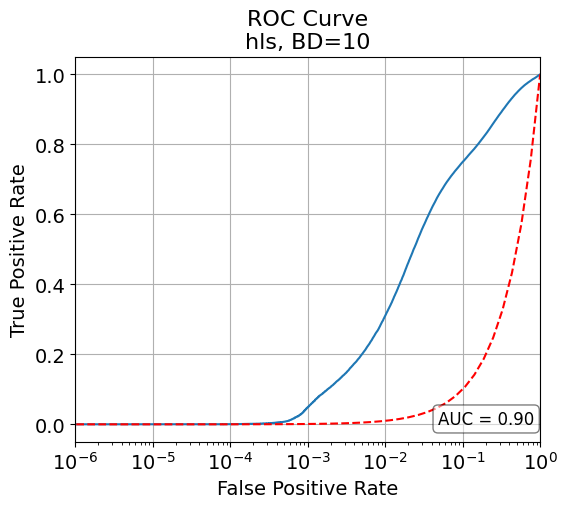

In [27]:
fpr, tpr, thresholds = roc_curve(y_test_true.ravel(), test_pred.ravel())
auc = roc_auc_score(y_test_true, test_pred, multi_class='ovr', average='micro')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(fpr, tpr)
x = np.logspace(-12, 0, 100)
ax.plot(x, x, 'r--')
ax.text(0.84, 0.001, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props, ha='right')
ax.set_xscale('log')
ax.set_xlim([1e-6, 1.0])
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title(f'ROC Curve\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

print('ROC AUC Score:', round(auc, 2))

In [28]:
best_10 = np.argsort(tpr-fpr)[::-1][:10]
print(tpr[best_10], fpr[best_10], sep='\n')
thresholds[best_10]

[0.76635044 0.76058883 0.76058262 0.76635665 0.76052053 0.76633181
 0.76051432 0.76633181 0.76058262 0.7605702 ]
[0.11652211 0.11077447 0.11076826 0.11654384 0.11070772 0.11652056
 0.11070462 0.11652211 0.11077447 0.11076205]


array([0.31347987, 0.32173524, 0.32174541, 0.31345687, 0.32182576,
       0.31349184, 0.32183233, 0.31348956, 0.32173582, 0.32175838])

In [31]:
loadarff('../data/hls4ml_jets/hls4ml_HLF.arff')[0][:10]

array([(-2.93512535, 0.38315532, 0.00512588, 8.42466834e-05, 0.00906996, 1.78931368e-04, 1.76944518, 2.12389827, 1.76944518, 0.30818543, 0.13568692, 0.08327801, 0.41213611, 0.29905787,   8.92688179,  75., b'g'),
       (-1.92733514, 0.27069876, 0.0015854 , 1.13709866e-05, 0.00323237, 2.91449633e-05, 2.03883362, 2.56309891, 2.03883362, 0.2118865 , 0.06372858, 0.0363104 , 0.31021652, 0.22666131,   3.88651156,  31., b'w'),
       (-3.11214662, 0.45817113, 0.09791385, 2.85884105e-02, 0.12427754, 3.84868123e-02, 1.26925385, 1.34623826, 1.26925385, 0.24648811, 0.11563597, 0.07909413, 0.35755852, 0.28921959, 162.14466858,  61., b't'),
       (-2.66651511, 0.4370676 , 0.04912205, 7.97829404e-03, 0.04747669, 4.80184611e-03, 0.96650451, 0.60186374, 0.96650451, 0.16075641, 0.08219644, 0.0333105 , 0.23887058, 0.09451606,  91.25893402,  39., b'z'),
       (-2.48484278, 0.42898133, 0.04178597, 6.10950543e-03, 0.02306595, 1.12305430e-03, 0.55200213, 0.18382081, 0.55200213, 0.08433798, 0.04800634, 0.0

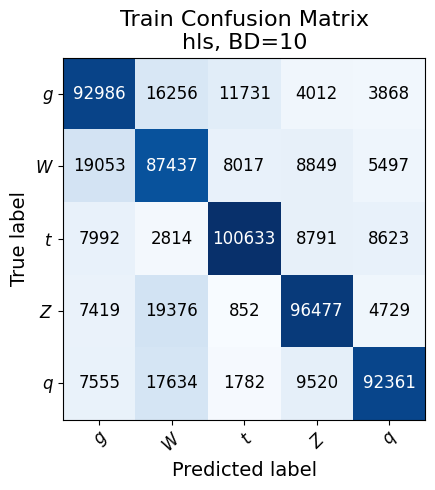

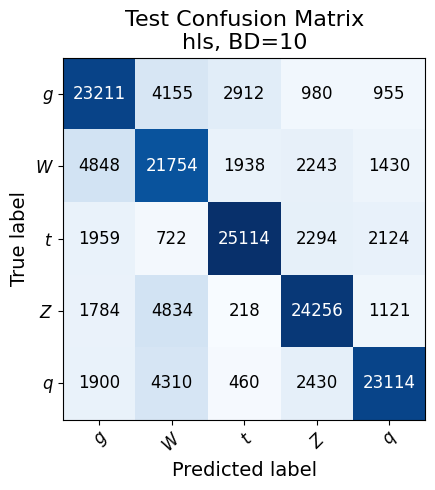

In [32]:
thresh = 0.5
fig, ax = plot_confusion_matrix(train_pred, y_train_true, [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'], thresh=thresh)
ax.set_title(f'Train Confusion Matrix\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/train_confusion_matrix_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

fig, ax = plot_confusion_matrix(test_pred, y_test_true, [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'], thresh=thresh)
ax.set_title(f'Test Confusion Matrix\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/test_confusion_matrix_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [33]:
#save model weights
#np.savez(MODEL_DIR + f'/weights_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name : value.cpu().detach() for key, value in model._TTN__tensor_map.items()})
model.to_npz(MODEL_DIR + f'/model_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz')

### Correlations

In [34]:
sz = torch.tensor([[1, 0], [0, -1]], dtype = DTYPE, device = DEVICE)

In [35]:
feat_combos = combinations_with_replacement(np.arange(model.n_features), 2)
feat_combos = [combo for combo in feat_combos if combo[0] != combo[1]]
corr = np.empty((model.n_features, model.n_features, model.n_labels))
corr.fill(np.nan)

for combo in feat_combos:
    corr[combo] = model.expectation({TIndex(f'data.{i}', [f'data.{i}']): sz for i in combo}).cpu().numpy()

for n in range(model.n_features):
    corr[n, n] = model.expectation({TIndex(f'data.{n}', [f'data.{n}']): sz@sz}).cpu().numpy()


In [36]:
def plot_correlations(corr, features, labels, fig=None, axs=None):
    n_feat = len(features)
    if axs is None:
        fig, axs = plt.subplots(1, len(labels), figsize=(n_feat*len(labels), n_feat))
    axs = np.atleast_1d(axs)
    for i, ax in enumerate(axs):
        im = ax.imshow(corr[:, :, i].T, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal')
        ax.set_xticks(np.arange(n_feat), features, fontsize=FONTSIZE, rotation=45)
        ax.set_yticks(np.arange(n_feat), features, fontsize=FONTSIZE)
        # Minor ticks
        ax.set_xticks(np.arange(-.5, n_feat-1, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n_feat-1, 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
        #ax.set_xticklabels(features)
        #ax.set_yticklabels(features)
        ax.set_title(labels[i], fontsize=FONTSIZE+2)
        for n in range(n_feat):
            for m in range(n+1):
                text = ax.text(m, n, round(corr[m, n, i], 2), ha='center', va='center', color='black', fontsize=FONTSIZE-2)
    return fig, axs

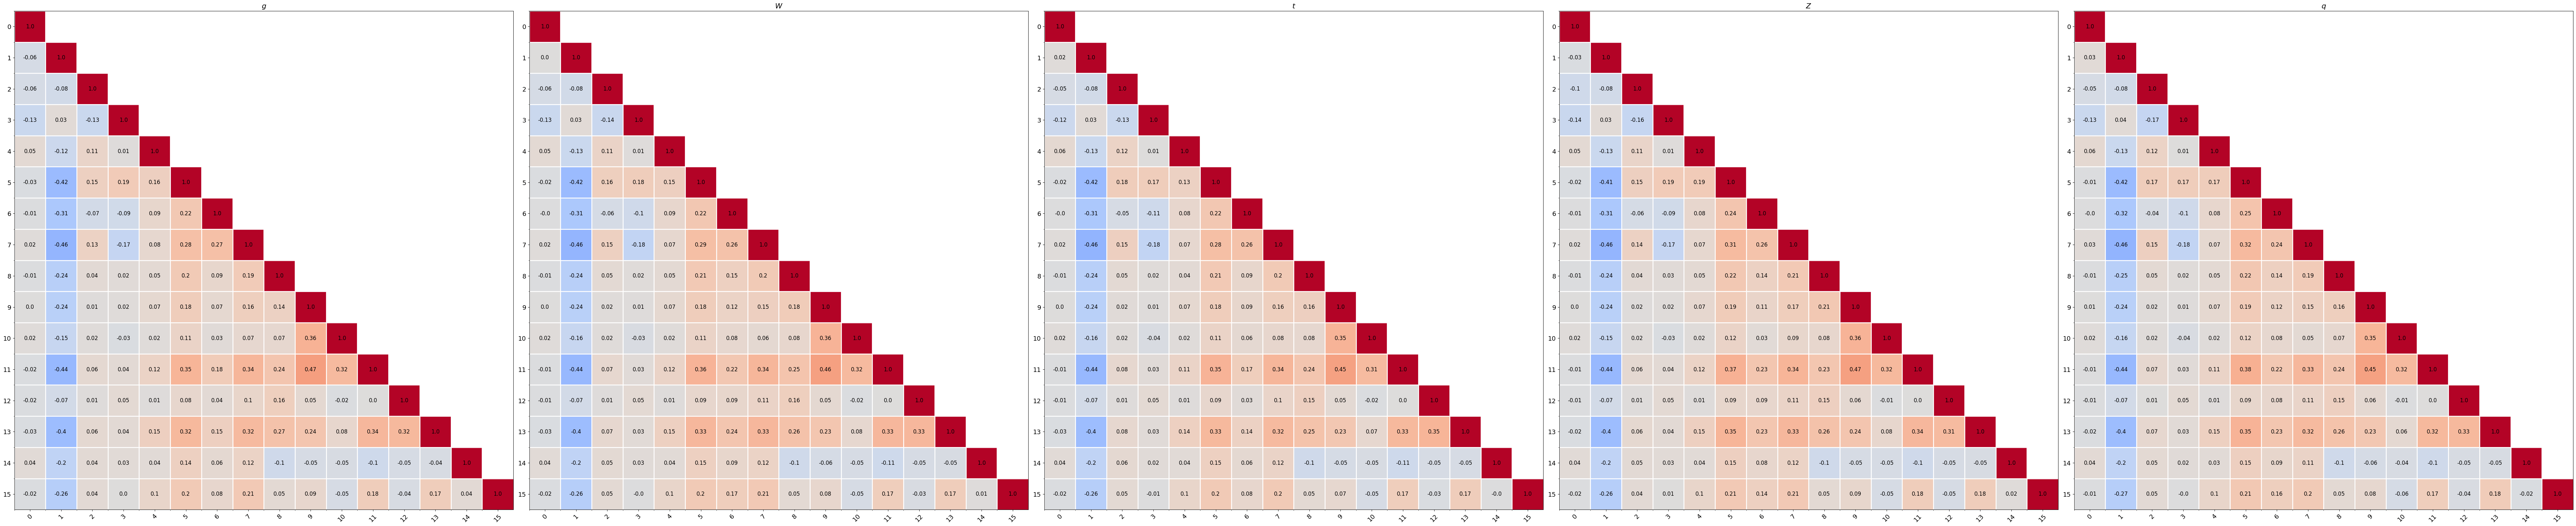

In [38]:
fig, axs = plot_correlations(corr, [i for i in range(16)], [r'$g$', r'$W$', r'$t$', r'$Z$', r'$q$'])
#fig.suptitle(r'$\sigma_z$ correlations between features', fontsize=FONTSIZE+2)
#fig.subplots_adjust()
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/correlations_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

#fig.savefig('trenti_models/train_lhcb_bd8/correlations.png')

### Entropy

In [39]:
model.canonicalize('0.0')

In [40]:
feat_entropies = [value for key, value in model.get_entropies().items() if 'data' in key]
print('features entropies:', feat_entropies)
print('total feat entropy:', sum(feat_entropies))

features entropies: [tensor([0.5015, 0.4405, 0.4405, 0.4405, 0.4405], dtype=torch.float64), tensor([0.3376, 0.3017, 0.3017, 0.3017, 0.3017], dtype=torch.float64), tensor([0.6805, 0.6359, 0.6359, 0.6359, 0.6359], dtype=torch.float64), tensor([0.6856, 0.6912, 0.6912, 0.6912, 0.6912], dtype=torch.float64), tensor([0.6687, 0.6557, 0.6557, 0.6557, 0.6557], dtype=torch.float64), tensor([0.4977, 0.4371, 0.4371, 0.4371, 0.4371], dtype=torch.float64), tensor([0.5017, 0.5150, 0.5150, 0.5150, 0.5150], dtype=torch.float64), tensor([0.5112, 0.5727, 0.5727, 0.5727, 0.5727], dtype=torch.float64), tensor([0.4332, 0.3154, 0.3154, 0.3154, 0.3154], dtype=torch.float64), tensor([0.4611, 0.4307, 0.4307, 0.4307, 0.4307], dtype=torch.float64), tensor([0.5545, 0.4978, 0.4978, 0.4978, 0.4978], dtype=torch.float64), tensor([0.5269, 0.5077, 0.5077, 0.5077, 0.5077], dtype=torch.float64), tensor([0.5172, 0.4431, 0.4431, 0.4431, 0.4431], dtype=torch.float64), tensor([0.5403, 0.5039, 0.5039, 0.5039, 0.5039], dtype=t

In [42]:
print('most informative features:', np.array([i for i in range(16)])[np.argsort(np.concatenate(feat_entropies))[::-1]])

IndexError: index 18 is out of bounds for axis 0 with size 16

In [47]:
np.argsort(feat_entropies, axis=0)[:,0]

array([3, 0, 1, 6, 5, 7, 4, 2])

In [64]:
list(zip(feat_entropies, titanic_features))

[(tensor([0.6319], dtype=torch.float64), 'pclass'),
 (tensor([0.6322], dtype=torch.float64), 'sex'),
 (tensor([0.6617], dtype=torch.float64), 'age'),
 (tensor([0.6170], dtype=torch.float64), 'sibsp'),
 (tensor([0.6527], dtype=torch.float64), 'parch'),
 (tensor([0.6491], dtype=torch.float64), 'ticket'),
 (tensor([0.6345], dtype=torch.float64), 'fare'),
 (tensor([0.6523], dtype=torch.float64), 'embarked')]

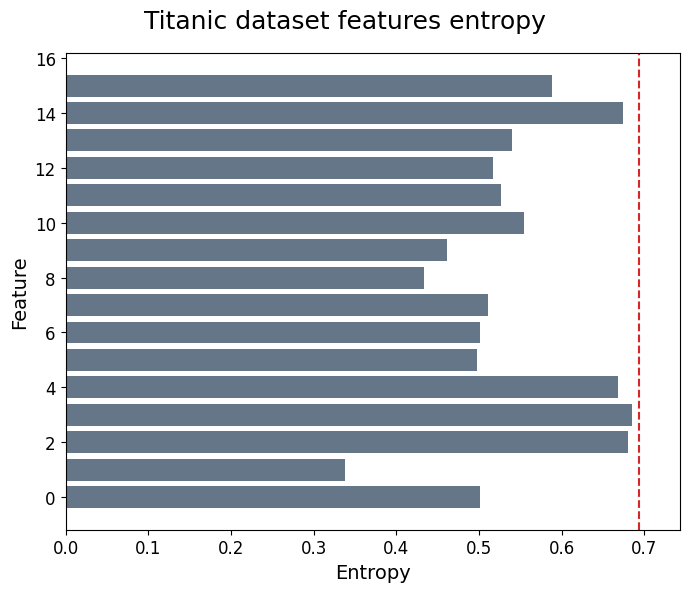

In [44]:
feat_entropies_ordered, perm = np.sort(feat_entropies, axis=0), np.argsort(feat_entropies, axis=0)[:,0] 

fig, ax = plot_feat_en(feat_entropies_ordered, np.array([i for i in range(16)])[perm], 'Titanic', map_dim=MAP_DIM, FS=FONTSIZE, color='#647687')
fig.tight_layout()
fig.savefig(MODEL_DIR + f'/features_entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.pdf') #_{now.strftime("%Y%m%d-%H%M%S")}

In [46]:
def draw_mi(model, cmap='Reds'):
    mi = model.get_mi()
    cmap = colormaps.get_cmap('Reds')
    min, max = np.min(list(mi.values())), np.max(list(mi.values()))
    dot = graphviz.Digraph('Entropy', comment='TTN: ' + 'Entropy', engine='dot', format='svg', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
    dot.attr('node', shape='circle', width='0.5', fixedsize='true', fontsize=str(11))
    dot.attr('edge', color='#bfbfbf', fontsize=str(11-2))
    dot.edge('0.0', 'hide', label=model.label_tag)
    dot.node('hide', '', shape='plaintext')
    for i, tindex in enumerate(model.indices):
        c_rgba = list(cmap((mi[tindex.indices[-1]]-min)/(max-min)))
        
        dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
        
        dot.edge(tindex[0], tindex.name, label=str(tindex[0])+f' [{model.tensors[i].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
        dot.edge(tindex[1], tindex.name, label=str(tindex[1])+f' [{model.tensors[i].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))

    for i in range(2**model.n_layers):
        index = f'data.{i}'
        c_rgba = list(cmap((mi[index]-min)/(max-min)))
        dot.node(index, index, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')

    return dot

def draw_entropy(model, features=None, labels=None, cmap='Reds'):
    entropies = model.get_entropies()
    n_labels = model.n_labels
    cmap = colormaps.get_cmap('Reds')
    min, max = np.min(np.stack(list(entropies.values())), axis=0), np.max(np.stack(list(entropies.values())), axis=0)
    print(min, max)
    dots = []

    for j in range(n_labels):

        dot = graphviz.Digraph('Entropy', comment='TTN: ' + 'Entropy', engine='dot', format='svg', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'8,6', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.5', fixedsize='true', fontsize=str(11))
        dot.attr('edge', color='#bfbfbf', fontsize=str(11-2))
        dot.edge('0.0', 'hide', label=model.label_tag if labels is None else labels[j])
        dot.node('hide', '', shape='plaintext')
        for i, tindex in enumerate(model.indices):
            c_rgba = (0,0,0,0) if tindex.indices[-1] == 'label' else list(cmap((entropies[tindex.indices[-1]][j]-min[j])/(max[j]-min[j])))
            
            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=str(tindex[0])+f' [{model.tensors[i].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=str(tindex[1])+f' [{model.tensors[i].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))

        for i in range(2**model.n_layers):
            index = f'data.{i}'
            c_rgba = list(cmap((entropies[index][j]-min[j])/(max[j]-min[j])))
            dot.node(index, index if features is None else features[i], fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
        dots.append(dot)

    return dots

In [51]:
dot = draw_mi(model)
dot

RuntimeError: a Tensor with 3 elements cannot be converted to Scalar

In [47]:
model.get_entropies()

{np.str_('1.0'): tensor([1.3797e+00, 1.8886e-05, 1.3913e-05, 2.6353e-05, 1.7242e-05],
        dtype=torch.float64),
 np.str_('1.1'): tensor([1.3797e+00, 1.8886e-05, 1.3913e-05, 2.6353e-05, 1.7242e-05],
        dtype=torch.float64),
 np.str_('2.0'): tensor([1.7919, 1.4698, 1.4698, 1.4698, 1.4698], dtype=torch.float64),
 np.str_('2.1'): tensor([1.7958, 1.4698, 1.4698, 1.4698, 1.4698], dtype=torch.float64),
 np.str_('2.2'): tensor([1.5335, 0.9773, 0.9773, 0.9773, 0.9773], dtype=torch.float64),
 np.str_('2.3'): tensor([1.7407, 0.9773, 0.9773, 0.9773, 0.9773], dtype=torch.float64),
 np.str_('3.0'): tensor([0.8213, 0.7106, 0.7106, 0.7106, 0.7106], dtype=torch.float64),
 np.str_('3.1'): tensor([1.3418, 1.2962, 1.2962, 1.2962, 1.2962], dtype=torch.float64),
 np.str_('3.2'): tensor([1.1053, 0.9529, 0.9529, 0.9529, 0.9529], dtype=torch.float64),
 np.str_('3.3'): tensor([0.9420, 0.9738, 0.9738, 0.9738, 0.9738], dtype=torch.float64),
 np.str_('3.4'): tensor([0.8611, 0.6937, 0.6937, 0.6937, 0.6937]

[3.36748470e-01 1.88858835e-05 1.39131217e-05 2.63528643e-05
 1.72422091e-05] [1.80030394 1.46984078 1.46983978 1.46984231 1.46984045]


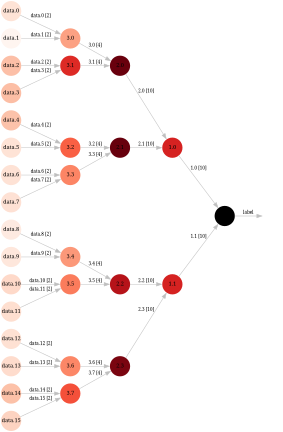

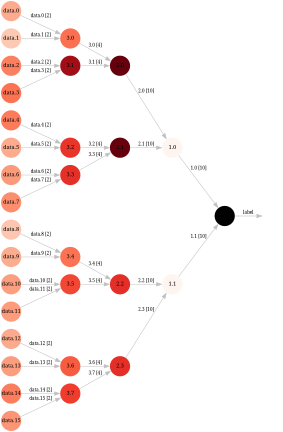

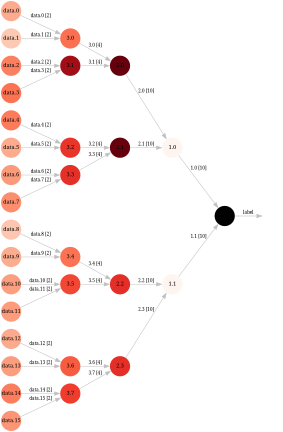

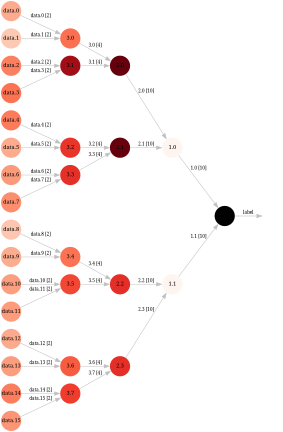

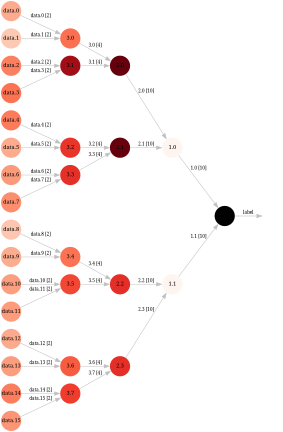

In [48]:
dots = draw_entropy(model, features=None)
for i, dot in enumerate(dots):
    display(SVG(dot.pipe(format='svg')))
    dot.render(MODEL_DIR + f'/entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_l{i}_{now.strftime("%Y%m%d-%H%M%S")}', format='pdf', cleanup=True)
    #dot.render('trenti_models/train_lhcb_bd8/entropy_l' + str(i), format='svg', cleanup=True)
    

In [207]:
dot.render(MODEL_DIR + f'/mi_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}', format='png', cleanup=True)

'iris_models/mi_iris_bd3_poly_20240327-212513.cairo.png'

In [115]:
svg = skunk.layout_svgs([MODEL_DIR + f'/entropy_{DATASET}_bd{BOND_DIM}_{MAPPING}_l{i}_{now.strftime("%Y%m%d-%H%M%S")}.cairo.svg' for i in range(model.n_labels)],
                        #labels=['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'],
                        shape=(1, 3), figsize=(20, 6), fontsize=FONTSIZE+2)

ValueError: Bad shape specification

In [62]:
skunk.display(svg)

In [63]:
with open('entropy.svg', 'w') as f:
    f.write(svg)

In [45]:
data = []
labels = []

for x, y in train_dl:
    data.append(x)
    labels.append(y)

for x, y in test_dl:
    data.append(x)
    labels.append(y)

data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

#np.save(MODEL_DIR + f'/data_{DATASET}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', data)
#np.save(MODEL_DIR + f'/labels_{DATASET}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', labels)

(array([  2.,   3.,   4.,  23.,  28.,  52.,  70., 132., 248., 288.]),
 array([6.123234e-17, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00]),
 <BarContainer object of 10 artists>)

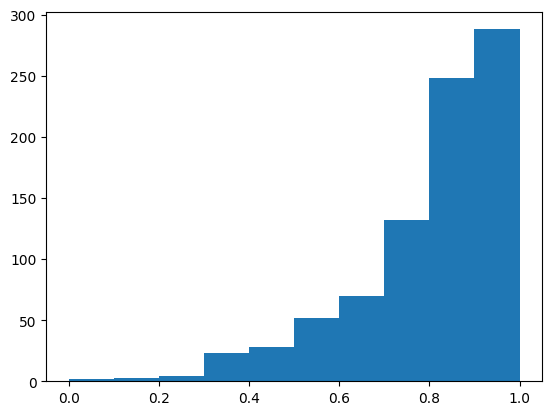

In [58]:
plt.hist(data[:,np.nonzero(np.array(titanic_features) == 'age')[0][0], 0].flatten())

## Get weights distribution

In [162]:
def get_weights_population(n, dataloader, disable_pbar=False, **kws):
    weights_ls = []
    DEVICE = 'cuda'
    BATCH_SIZE = 64
    DTYPE = torch.double
    INIT_EPOCHS = 5
    LR = 0.05
    EPOCHS = 80
    SCHEDULER_STEPS = 4
    train_dl, test_dl, features = dataloader(batch_size=BATCH_SIZE, **kws)

    label_shape = next(iter(train_dl))[1].shape
    N_LABELS = 1 if len(label_shape) == 1 else label_shape[1]
    
    pbar = tqdm(total=n*EPOCHS*len(train_dl), position=0, desc='weights population', leave=True, disable=disable_pbar)
    for _ in range(n):        
        model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
        model.initialize(True, train_dl, class_loss, INIT_EPOCHS, disable_pbar=True)
        model.train()
        model.to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
        scheduler = schedulers[0]
        tot_loss_history = []
        for epoch in range(EPOCHS):
            loss_history = train_one_epoch(model, DEVICE, train_dl, class_loss, optimizer, pbar=pbar, disable_pbar=disable_pbar)
            tot_loss_history += loss_history
            if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
                scheduler.step()

        loss_history = np.array(tot_loss_history)
        print('Accuracy on train and test set:', accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True))

        weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
        weights_ls.append(torch.concat(weights, dim=0))
        train_dl, test_dl, h = dataloader(batch_size=BATCH_SIZE, **kws)
    return torch.stack(weights_ls)

In [163]:
BOND_DIM = 10
weights = get_weights_population(5, get_titanic_data_loaders)

weights population:  20%|██        | 1120/5600 [00:45<02:50, 26.26it/s, current loss=0.0179, batches 0-10 loss=0.0884, epoch mean loss=0.0826]

Accuracy on train and test set: (0.7709832134292566, 0.7751196172248804)


weights population:  40%|████      | 2240/5600 [01:31<02:07, 26.43it/s, current loss=0.00987, batches 0-10 loss=0.0898, epoch mean loss=0.0837]

Accuracy on train and test set: (0.762589928057554, 0.8038277511961722)


weights population:  60%|██████    | 3360/5600 [02:17<01:24, 26.48it/s, current loss=0.0152, batches 0-10 loss=0.0905, epoch mean loss=0.0824] 

Accuracy on train and test set: (0.7997601918465228, 0.8038277511961722)


weights population:  80%|████████  | 4480/5600 [03:03<00:42, 26.64it/s, current loss=0.0278, batches 0-10 loss=0.0893, epoch mean loss=0.0857]

Accuracy on train and test set: (0.7805755395683454, 0.7751196172248804)


weights population: 100%|██████████| 5600/5600 [03:50<00:00, 24.31it/s, current loss=0.00934, batches 0-10 loss=0.0808, epoch mean loss=0.08]  

Accuracy on train and test set: (0.7889688249400479, 0.7464114832535885)


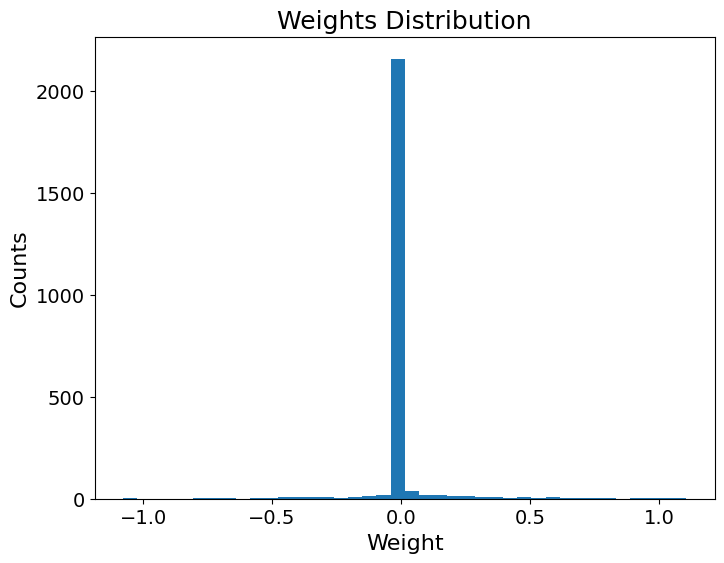

In [177]:
weights_plt = weights.flatten().numpy()
np.save(f'models/weights_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.npy', weights.numpy())
FS = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(weights_plt, bins=40)
ax.set_xlabel('Weight', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Weights Distribution', fontsize=FS+2)
ax.tick_params(axis='both', which='major', labelsize=FS-2)
#ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)

fig.savefig(f'models/weight_distribution_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.svg')

In [11]:
weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
weights = torch.concat(weights, dim=0)
weights

tensor([-9.2217e-01, -4.2329e-01,  4.4709e-01, -7.4299e-02,  3.6544e-01,
         3.4145e-01,  9.7104e-02,  1.1460e-01,  8.4942e-02,  4.1804e-01,
        -2.0786e-01,  5.0099e-01,  5.1867e-01,  5.7739e-01,  2.0253e-02,
         6.7193e-03,  2.1394e-01,  5.1458e-01,  3.8172e-01,  1.1885e-01,
         4.4091e-01, -2.6139e-01, -4.2266e-03,  1.0388e-02, -5.1384e-01,
         5.5568e-01, -2.8352e-01,  1.0219e-01,  4.4307e-01,  2.8679e-01,
        -5.1136e-02, -5.8614e-02,  2.2028e-01, -2.7422e-01, -5.2680e-01,
        -1.7147e-01, -1.9369e-01, -1.0301e-01,  7.6463e-01, -2.1637e-01,
         8.6044e-01,  6.4869e-02, -1.3599e-01, -3.5713e-01,  2.6609e-01,
        -5.4260e-01, -2.7559e-02,  7.0734e-02,  3.4830e-02,  2.6921e-02,
         2.9916e-02, -9.8469e-02, -5.0250e-02, -3.0016e-02,  6.9496e-01,
         1.0065e+00, -1.4466e-01,  1.2498e-01, -5.6093e-01, -8.0377e-02,
         5.5591e-01, -3.0993e-01,  1.3394e-01,  3.2452e-01, -4.5843e-01,
        -2.1284e-01, -2.8563e-01,  6.4911e-01,  1.5

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,
        10., 10.,  6., 15., 18., 25., 40., 90., 48., 33., 17., 19., 12.,
         7.,  9.,  1.,  2.,  3.,  3.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([-2.97877278, -2.83406458, -2.68935638, -2.54464818, -2.39993999,
        -2.25523179, -2.11052359, -1.96581539, -1.8211072 , -1.676399  ,
        -1.5316908 , -1.3869826 , -1.24227441, -1.09756621, -0.95285801,
        -0.80814981, -0.66344162, -0.51873342, -0.37402522, -0.22931702,
        -0.08460883,  0.06009937,  0.20480757,  0.34951576,  0.49422396,
         0.63893216,  0.78364036,  0.92834855,  1.07305675,  1.21776495,
         1.36247315,  1.50718134,  1.65188954,  1.79659774,  1.94130594,
         2.08601413,  2.23072233,  2.37543053,  2.52013873,  2.66484692,
         2.80955512]),
 <BarContainer object of 40 artists>)

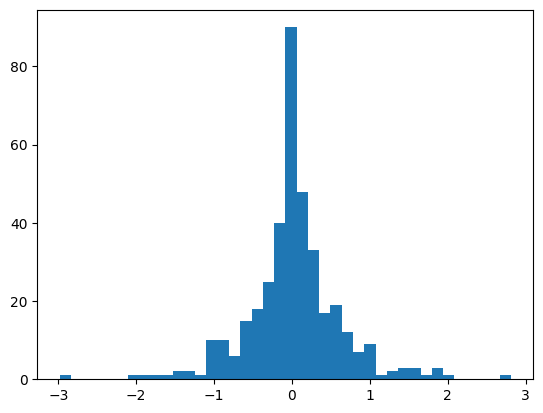

In [15]:
plt.hist(weights, bins=40)

In [14]:
print('min', np.abs(weights.numpy()).min(), 'max', np.abs(weights.numpy()).max(), sep='\n')

min
0.0001989706422858017
max
2.978772776316998


In [13]:
print('min', np.abs(weights.numpy()).min(axis=1).mean(), 'max', np.abs(weights.numpy()).max(axis=1).mean(), sep='\n')

AxisError: axis 1 is out of bounds for array of dimension 1

# Quantized model

In [4]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 4
fl = 2

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="nearest")

MODEL_DIR = 'qmodels'

In [5]:
fixed_point_quantize(torch.tensor([1.2, 1e-5, 3.4, -0.8]), 6, 4, rounding='nearest', symmetric=True)

tensor([ 1.1875,  0.0000,  1.9375, -0.8125])

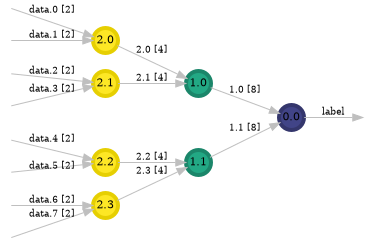

In [5]:
DEVICE = 'cuda'
BOND_DIM = 8
DTYPE = torch.float        # we use float for the quantization, as qtorch does not support double
N_LABELS = 1

qmodel = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE, quantizer=Q)
qmodel.draw()

In [8]:
test = next(iter(train_dl))[0].to(DEVICE, dtype=DTYPE)
qmodel(test, quantize=False)

tensor([[ 0.3117],
        [ 0.2218],
        [-0.9170],
        [-0.7307],
        [ 0.3098],
        [-0.3790],
        [ 0.3108],
        [ 0.3061],
        [-0.3175],
        [-0.9547],
        [-0.9547],
        [ 0.2446],
        [ 0.2472],
        [-0.8134],
        [ 0.3394],
        [ 0.2151],
        [ 0.2978],
        [-0.9609],
        [-0.9466],
        [-0.7156],
        [ 0.3055],
        [-0.6844],
        [ 0.2553],
        [-0.3662],
        [ 0.0686],
        [ 0.0611],
        [ 0.2980],
        [-0.6676],
        [ 0.2663],
        [-0.7019],
        [ 0.2507],
        [ 0.2989],
        [ 0.2795],
        [ 0.0580],
        [ 0.1829],
        [-0.3181],
        [-0.0289],
        [ 0.2477],
        [ 0.3064],
        [-0.6222],
        [-0.6238],
        [-0.8812],
        [ 0.3801],
        [-0.8430],
        [-0.4489],
        [ 0.1656],
        [ 0.3842],
        [-0.6271],
        [ 0.1765],
        [-0.3492],
        [ 0.2016],
        [-0.4736],
        [ 0.

In [6]:
INIT_EPOCHS = 15

qmodel.initialize(True, train_dl, class_loss, INIT_EPOCHS)
summary(qmodel, input_size=(BATCH_SIZE, features, 2), dtypes=[DTYPE], device=DEVICE)

ttn supervised init:   0%|          | 0/11 [00:08<?, ?it/s, doing epoch 15/15]


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [64, 1]                   384
Total params: 384
Trainable params: 384
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [110]:
LR = 0.02
EPOCHS = 80
LAMBDA = 0.1
SCHEDULER_STEPS = 5


qmodel.train()
qmodel.to(DEVICE)
optimizer = torch.optim.Adam(qmodel.parameters(), lr=LR)
# define custom quantization functions for different numbers
weight_quant = lambda x : fixed_point_quantize(x, wl, fl, rounding="nearest")
# turn your optimizer into a low precision optimizer
optimizer = OptimLP(optimizer,
                    weight_quant=weight_quant)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [111]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(qmodel, DEVICE, train_dl, lambda *x: class_loss(*x, l=LAMBDA), optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs:   0%|          | 0/80 [00:00<?, ?it/s]

epochs: 100%|██████████| 80/80 [01:33<00:00,  1.17s/it]


In [112]:
accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE)

train:   0%|          | 0/6 [00:00<?, ?it/s]

train: 100%|██████████| 6/6 [00:00<00:00,  8.83it/s]


(0.7691176470588236, 0.7705882352941177)

In [113]:
torch.save(model.state_dict, MODEL_DIR + f'/trainedmodel_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.savez(MODEL_DIR + f'/modelweights_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name: value.cpu().detach() for key, value in qmodel._TTN__tensor_map.items()})

In [114]:
# save model output
train_out = get_output(qmodel, DEVICE, train_dl, DTYPE)
test_out = get_output(qmodel, DEVICE, test_dl, DTYPE)
np.save(MODEL_DIR + f'/train_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(MODEL_DIR + f'/test_out_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

test:   0%|          | 0/6 [00:00<?, ?it/s]

test: 100%|██████████| 2/2 [00:00<00:00, 253.26it/s]


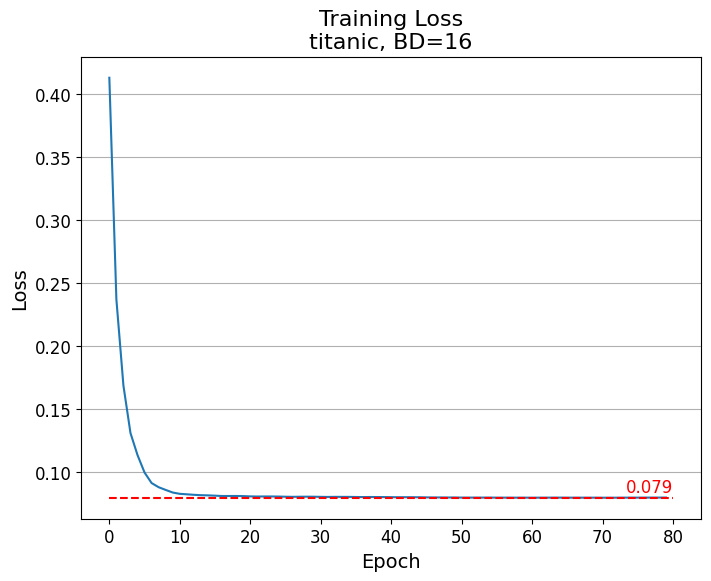

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else None)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch', fontsize=FONTSIZE)
ax.set_ylabel('Loss', fontsize=FONTSIZE)
ax.set_title(F'Training Loss\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax.grid(axis='y')

ax.hlines(loss_history[(EPOCHS-1)*len(train_dl):].mean(), 0, EPOCHS, colors='r', linestyles='dashed')
ax.text(EPOCHS, loss_history[(EPOCHS-1)*len(train_dl):].mean()+0.001, f'{loss_history[(EPOCHS-1)*len(train_dl):].mean():.3f}', fontsize=FONTSIZE-2, color='r', verticalalignment='bottom', horizontalalignment='right')

fig.savefig(MODEL_DIR + f'/loss_history_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png')

test:   0%|          | 0/6 [00:00<?, ?it/s]

test: 100%|██████████| 2/2 [00:00<00:00, 244.99it/s]


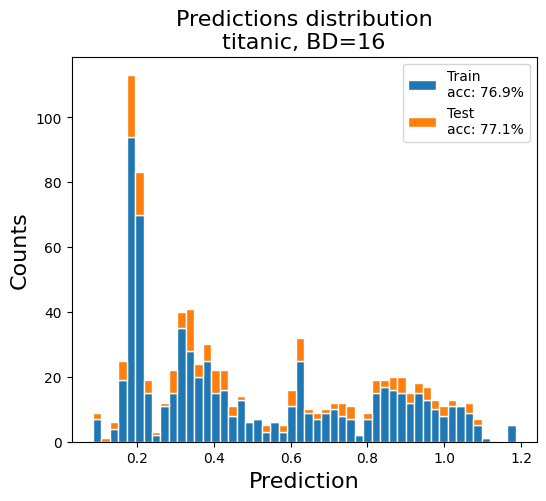

In [116]:
train_pred = get_predictions(qmodel, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(qmodel, DEVICE, test_dl, DTYPE)

fig, ax = plot_predictions(train_pred, test_pred, N_LABELS)

train_acc, test_acc = accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)

ax.legend([f'Train\nacc: {train_acc:.1%}', f'Test\nacc: {test_acc:.1%}'])
ax.set_title(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png')

ROC AUC Score: 0.81


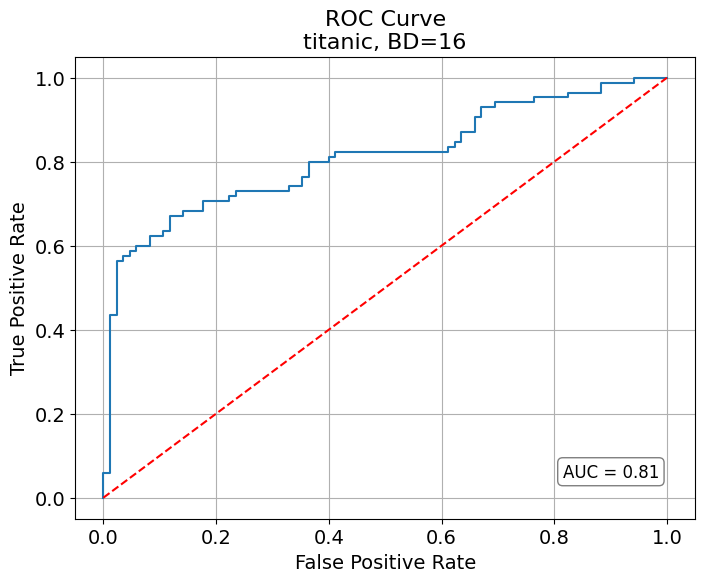

In [117]:
y_true = torch.cat([y for _, y in test_dl], dim=0).numpy()

fpr, tpr, thresholds = roc_curve(y_true, test_pred)
auc = roc_auc_score(y_true, test_pred)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title(f'ROC Curve\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.text(0.815, 0.05, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{DATASET}_bd{BOND_DIM}_{MAPPING}_{now.strftime("%Y%m%d-%H%M%S")}.png')

print('ROC AUC Score:', round(roc_auc_score(y_true, test_pred), 2))

In [43]:
tensors = torch.load('qmodels/trainedmodel_titanic_bd4_spin_20240213-140002.dict')()
list(tensors.values())[0].shape

torch.Size([8, 8, 1])

In [50]:
tensors = np.load('qmodels/modelweights_titanic_bd4_spin_20240213-140002.npz')
list(tensors.values())[0].shape

(4, 4, 1)

In [52]:
qmodel.tensors = [torch.tensor(tensor).to(dtype=torch.float, device='cuda') for tensor in tensors.values()]

In [61]:
qmodel['2.0']['2.0'].shape

torch.Size([2, 2, 4])

In [75]:
data = np.load('titanic_models/data_titanic_spin_20240213-134127.npy')
data = torch.tensor(data[:16], dtype=torch.float, device='cuda')
data

tensor([[[6.1232e-17, 1.0000e+00],
         [6.1232e-17, 1.0000e+00],
         [9.4565e-01, 3.2519e-01],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 8.1039e-05],
         [9.9976e-01, 2.1843e-02],
         [6.1232e-17, 1.0000e+00]],

        [[6.1232e-17, 1.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [8.3261e-01, 5.5386e-01],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [9.8128e-01, 1.9260e-01],
         [9.9977e-01, 2.1307e-02],
         [7.0711e-01, 7.0711e-01]],

        [[6.1232e-17, 1.0000e+00],
         [6.1232e-17, 1.0000e+00],
         [9.1715e-01, 3.9853e-01],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 1.3635e-03],
         [9.9975e-01, 2.2150e-02],
         [1.0000e+00, 0.0000e+00]],

        [[7.0711e-01, 7.0711e-01],
         [1.0000e+00, 0.0000e+00],
         [9.9097e-01, 1.3405e-01],
         [1.0000e+00, 0.0000e+00],
         [8.66

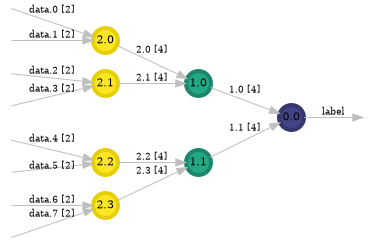

In [54]:
qmodel.draw()

In [56]:
branch = '2.0'
qmodel._propagate_data_through_branch_({TIndex(f'data.{i}', [f'data.{i}']): data[:, i] for i in range(2)}, qmodel.get_branch(branch), keep=True)

{TTNIndex: 2.0: tensor([[ 0.3688, -0.1398, -0.1765,  0.5350],
         [-0.1143,  0.1140,  0.4149, -0.2851],
         [ 0.3688, -0.1398, -0.1765,  0.5350],
         [ 0.1741,  0.1238,  0.7998, -0.1366],
         [ 0.3688, -0.1398, -0.1765,  0.5350],
         [ 0.1741,  0.1238,  0.7998, -0.1366],
         [ 0.2850, -0.1687, -0.3921,  0.5460],
         [-0.1143,  0.1140,  0.4149, -0.2851],
         [ 0.3688, -0.1398, -0.1765,  0.5350],
         [ 0.3604,  0.0610,  0.7162,  0.0920],
         [-0.1143,  0.1140,  0.4149, -0.2851],
         [ 0.2850, -0.1687, -0.3921,  0.5460],
         [ 0.0342, -0.0989, -0.3779,  0.2372],
         [ 0.1741,  0.1238,  0.7998, -0.1366],
         [ 0.3688, -0.1398, -0.1765,  0.5350],
         [-0.1143,  0.1140,  0.4149, -0.2851]], device='cuda:0')}

In [68]:
contract_up(qmodel[branch][branch], data[:2], quantizer=Q)

tensor([[ 0.3688, -0.1398, -0.1765,  0.5350],
        [-0.1143,  0.1140,  0.4149, -0.2851],
        [ 0.3372,  0.0020,  0.4465,  0.2158],
        [ 0.3604,  0.0610,  0.7162,  0.0920],
        [ 0.3604,  0.0610,  0.7162,  0.0920],
        [ 0.3602,  0.0408,  0.6299,  0.1360],
        [ 0.3586,  0.0613,  0.7168,  0.0911],
        [ 0.1800, -0.0182,  0.1685,  0.1768]], device='cuda:0')

In [80]:
quantizer = Q
tensor = qmodel[branch][branch]
data_tensors = data[:1,:2].transpose(0, 1)
tensor = quantizer(tensor)
left   = quantizer(torch.matmul(quantizer(data_tensors[0]), tensor.contiguous().view(tensor.shape[0], -1)))
right  = quantizer(torch.bmm(quantizer(data_tensors[1]).unsqueeze(1), left.view(-1, tensor.shape[1], tensor.shape[2])))

In [73]:
tensor
left

tensor([[-0.1143,  0.1140,  0.4149, -0.2851,  0.3688, -0.1398, -0.1765,  0.5350],
        [-0.1143,  0.1140,  0.4149, -0.2851,  0.3688, -0.1398, -0.1765,  0.5350]],
       device='cuda:0')

In [83]:
print('tensor:', tensor.permute(2, 0, 1))
print('left:', left)
print('right:', right)
print('data0:', quantizer(data_tensors[0]))
print('data1:', quantizer(data_tensors[1]))

tensor: tensor([[[ 0.3604,  0.0342],
         [-0.1143,  0.3688]],

        [[ 0.0610, -0.0989],
         [ 0.1140, -0.1398]],

        [[ 0.7162, -0.3779],
         [ 0.4149, -0.1765]],

        [[ 0.0920,  0.2372],
         [-0.2851,  0.5350]]], device='cuda:0')
left: tensor([[-0.1143,  0.1140,  0.4149, -0.2851,  0.3688, -0.1398, -0.1765,  0.5350]],
       device='cuda:0')
right: tensor([[[ 0.3688, -0.1398, -0.1765,  0.5350]]], device='cuda:0')
data0: tensor([[0., 1.]], device='cuda:0')
data1: tensor([[0., 1.]], device='cuda:0')


In [66]:
print(qmodel['2.0']['2.0'][-1, -1, -1].item())

0.5350341796875


# Trash

In [23]:
torch.load('data/grid_search/model_8_4_16_False_torch.float64.pth')['_TTN__tensors.0']

tensor([[[-3.7677e-04],
         [-1.5435e-02],
         [-1.8145e-04],
         [-6.1096e-04]],

        [[-7.9009e-04],
         [ 1.0263e+00],
         [ 5.1388e-05],
         [ 1.5473e-04]],

        [[ 7.0854e-04],
         [-3.7704e-03],
         [-9.0056e-05],
         [-2.6149e-04]],

        [[ 1.3896e-06],
         [ 3.0381e-06],
         [-4.7425e-08],
         [ 3.6490e-08]]], device='cuda:0', dtype=torch.float64)

In [24]:
data_arff = arff.load(open('../data/titanic/titanic.arff', 'r'))
dataframe = pd.DataFrame(data_arff['data'])
dataframe.columns = [x[0] for x in data_arff['attributes']]
dataframe.drop(columns=['name', 'cabin', 'body', 'boat', 'home.dest'], inplace=True)
dataframe.dropna(inplace=True)
dataframe.to_csv('../data/titanic/titanic.csv', index=False)
dataframe

,pclass,survived,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,1,female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,1,male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,0,female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,0,male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,0,female,25.0000,1.0,2.0,113781,151.5500,S
...,...,...,...,...,...,...,...,...,...
1301,3.0,0,male,45.5000,0.0,0.0,2628,7.2250,C
1304,3.0,0,female,14.5000,1.0,0.0,2665,14.4542,C
1306,3.0,0,male,26.5000,0.0,0.0,2656,7.2250,C
1307,3.0,0,male,27.0000,0.0,0.0,2670,7.2250,C


In [9]:
path = '../data'
train = torch.tensor(np.load(path + '/Higgs/higgs_train.npy'))
permutation = torch.randperm(train.shape[1])
train[:, permutation]

tensor([[0.0904, 0.0914, 0.0542,  ..., 0.0864, 0.1605, 0.0784],
        [0.0696, 0.0101, 0.2556,  ..., 0.0958, 0.1628, 0.0855],
        [0.1086, 0.0571, 0.0760,  ..., 0.0915, 0.1628, 0.0884],
        ...,
        [0.0738, 0.0417, 0.0953,  ..., 0.0465, 0.1630, 0.0200],
        [0.1266, 0.0523, 0.1389,  ..., 0.0470, 0.1904, 0.0359],
        [0.1017, 0.1164, 0.0242,  ..., 0.1215, 0.1623, 0.0765]])

In [21]:
torch.randperm(train.shape[1]).tolist()

[2, 3, 4, 6, 5, 7, 0, 1]

In [17]:
[np.random.permutation(4) for _ in range(5)]

[array([0, 1, 3, 2]),
 array([1, 2, 0, 3]),
 array([2, 3, 0, 1]),
 array([1, 2, 3, 0]),
 array([0, 1, 3, 2])]